# Features

In this book we make an attempt to create features based on bids and asks in a limit orderbook.
We discuss what how the data could be processed such that machine learning models can understand certain patterns and possibly act in favour of execution optimization.

In [1]:
%cd ..

/Volumes/Data/dev/ctc-executioner


In [2]:
from orderbook import Orderbook

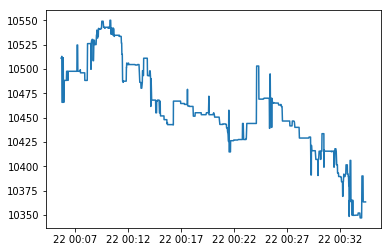

In [4]:
orderbook = Orderbook()
orderbook.loadFromEvents('ob-1-small.tsv')
orderbook.plot()

First we draw a random state (index) from the orderbook with which we have enough time remaining to proceed an execution of 120 seconds.

In [5]:
state, state_index = orderbook.getRandomState(120)
state

----------ORDERBOOK STATE----------
DateTime: 2018-02-22 00:29:56.161000
Price: 11548.84499998
Buyers: [10382.09826702: 2.6507577799999997, 10382.098267: 0.10951860000000002, 10375.0: 0.00102154, 10373.99: 0.40448772, 10364.31: 1.5102977899999999, 10360.5421125: 0.00105723, 10350.30812994: 0.00048433, 10350.0: 0.04762781, 10349.66: 0.557, 10347.6: 0.557, 10347.0: 1.71272895, 10325.69254486: 0.001, 10319.09994406: 0.828, 10319.09994405: 4.42704732, 10315.08878113: 2.41545983, 10302.71393373: 0.00047993, 10300.0: 1.59545553, 10297.05081026: 0.01010764, 10296.7575: 0.08425419999999999, 10286.825: 0.09848103, 10284.48125: 0.21075618, 10281.13398363: 0.01672194, 10281.06: 1.12, 10272.6639943: 0.00116559, 10271.179: 2.1679, 10260.99999999: 4.0, 10255.1322809: 0.0261802, 10250.0: 5.78221312, 10248.99000001: 0.35144304, 10239.90571194: 0.7771438, 10236.0: 0.53919278, 10225.99999999: 0.00848994, 10221.30067433: 0.00122387, 10219.48498969: 0.00070326, 10200.0: 3.3865180300000004, 10175.01391297:

Here the bids and asks in dictionary form.

In [6]:
d_state = orderbook.getDictState(state_index)
d_state

{'asks': {10432.0: 0.9414823800000001,
  10435.0: 0.18502858,
  10440.0: 0.06908381,
  10442.00000001: 0.6058005799999999,
  10450.9: 1.20928996,
  10451.0: 0.08033343,
  10468.9: 0.03,
  10478.0: 0.6933954999999999,
  10484.9: 1.0,
  10499.69999999: 4.19986931,
  10500.0: 10.33336236,
  10504.0: 0.19208661,
  10505.96344958: 3.51710348,
  10505.96344959: 4.922077359999999,
  10506.92168408: 2.04471619,
  10516.0: 1.4646772099999998,
  10523.25: 0.524,
  10525.31: 0.524,
  10528.0380415: 0.76775152,
  10533.23896501: 0.001,
  10533.54153572: 0.13,
  10538.4: 0.24,
  10545.0: 0.1,
  10548.0: 0.10712896,
  10550.0: 6.19197361,
  10557.735: 2.1679,
  10557.73588697: 0.00044074,
  10560.0: 0.04431027,
  10560.93874059: 0.06429247,
  10563.0: 0.01578543,
  10570.0: 0.34896438,
  10598.8251: 0.6,
  10599.09960937: 0.98129388,
  10600.0: 25.022806720000002,
  10609.58243497: 0.002,
  10622.0: 0.03,
  10633.0: 0.03,
  10640.0: 16.572190159999998,
  10644.0: 7.31309508,
  10650.0: 3.71174711,
 

# Private Variables

Private variables in the context of order execution is a tuple of the remaining time (seconds) and inventory (share size).

In [7]:
(120, 1.0) # 1.0 BTC left to be executed within 120 seconds

(120, 1.0)

# Market Variables

Market variables contain information derived from the market at the time right before the execution is being placed.

In [8]:
import numpy as np
from collections import OrderedDict
import pandas as pd

In [9]:
state = orderbook.getDictState(state_index)
asks = state['asks']
bids = state['bids']
bestAsk = min(asks.keys())

We now represent the bids and asks as a numpy array in the shape of `(2, levels, count(features))`.
In case both features, price and size are enabled, the output is as follows:

```
[
    [
        [bid_price  bid_size]
        [...        ...     ]
    ]
    [
        [ask_price  ask_size]
        [...        ...     ]
    ]
]
```

If eiether price or size is choosen only, the output has the shape `(2, levels)` and is as follows:

```
[
    [
        bid_price
        ...
    ]
    [
        ask_price
        ...      
    ]
]
```

or respectively:

```
[
    [
        bid_size
        ...     
    ]
    [
        ask_size
        ...     
    ]
]
```

In [10]:
def getBidAskFeature(bids, asks, qty=None, price=True, size=True, normalize=False, levels=20):
    """Creates feature to represent bids and asks.

    The prices and sizes of the bids and asks are normalized by the provided
    (naturally current) bestAsk and the provided quantity respectively.
    
    Shape: (2, levels, count(features)), whereas features can be [price, size]
    [
        [
            [bid_price  bid_size]
            [...        ...     ]
        ]
        [
            [ask_price  ask_size]
            [...        ...     ]
        ]
    ]
      
    """
    assert(price is True or size is True)
    
    def toArray(d):
        s = pd.Series(d, name='size')
        s.index.name='price'
        s = s.reset_index()
        return np.array(s)

    def force_levels(a, n=levels):
        """Shrinks or expands array to n number of records."""
        gap = (n - a.shape[0])
        if gap > 0:
            gapfill = np.zeros((gap, 2))
            a = np.vstack((a, gapfill))
            return a
        elif gap <= 0:
            return a[:n]

    bids = OrderedDict(sorted(bids.items(), reverse=True))
    asks = OrderedDict(sorted(asks.items()))
    bids = toArray(bids)
    asks = toArray(asks)
    if normalize is True:
        assert(qty is not None)
        bestAsk = np.min(asks[:,0])
        bids = np.column_stack((bids[:,0] / bestAsk, bids[:,1] / qty))
        asks = np.column_stack((asks[:,0] / bestAsk, asks[:,1] / qty))

    bidsAsks = np.array([force_levels(bids), force_levels(asks)])    
    if price is True and size is True:
        return bidsAsks
    if price is True:
        return bidsAsks[:,:,0]
    if size is True:
        return bidsAsks[:,:,1]


In [11]:
feature_ba = getBidAskFeature(d_state['bids'], d_state['asks'], qty=1.0, normalize=True, price=True, size=True, levels = 10)
print(feature_ba.shape)
print(feature_ba)

(2, 10, 2)
[[[9.95216475e-01 2.65075778e+00]
  [9.95216475e-01 1.09518600e-01]
  [9.94536043e-01 1.02154000e-03]
  [9.94439225e-01 4.04487720e-01]
  [9.93511311e-01 1.51029779e+00]
  [9.93150126e-01 1.05723000e-03]
  [9.92169108e-01 4.84330000e-04]
  [9.92139571e-01 4.76278100e-02]
  [9.92106979e-01 5.57000000e-01]
  [9.91909509e-01 5.57000000e-01]]

 [[1.00000000e+00 9.41482380e-01]
  [1.00028758e+00 1.85028580e-01]
  [1.00076687e+00 6.90838100e-02]
  [1.00095859e+00 6.05800580e-01]
  [1.00181173e+00 1.20928996e+00]
  [1.00182132e+00 8.03334300e-02]
  [1.00353719e+00 3.00000000e-02]
  [1.00440951e+00 6.93395500e-01]
  [1.00507094e+00 1.00000000e+00]
  [1.00648965e+00 4.19986931e+00]]]


In [12]:
feature_ba = getBidAskFeature(d_state['bids'], d_state['asks'], qty=1.0, normalize=True, price=True, size=False, levels = 5)
print(feature_ba)

[[0.99521647 0.99521647 0.99453604 0.99443923 0.99351131]
 [1.         1.00028758 1.00076687 1.00095859 1.00181173]]


Given the function `getBidAskFeature` with which we can represent the order book state as a numpy array, we now want to combine a certain number of states into one data structure.
Hence, a `lookback` is defined which tells how many states in the past (relative to the `state_index`) shall be considered.

The output of this funciton

In [13]:
def getBidAskFeatures(d, state_index, lookback, qty=None, price=True, size=True, normalize=False, levels=20):
    """ Creates feature to represent bids and asks with a lookback of previous states.
    
    Shape: (2*lookback, levels, count(features))
    """
    state = d[list(d.keys())[state_index]]
    asks = state['asks']
    bids = state['bids']
    bestAsk = min(asks.keys())
    i = 0
    while i < lookback:
        state_index = state_index - 1
        state = d[list(d.keys())[state_index]]
        asks = state['asks']
        bids = state['bids']
        features_next = getBidAskFeature(
                            bids=bids, 
                            asks=asks, 
                            qty=qty, 
                            price=price, 
                            size=size, 
                            normalize=normalize, 
                            levels=levels
                        )
        if i == 0:
            features = features_next
        else:
            features = np.vstack((features, features_next))
        i = i + 1
    return features

In [15]:
features = getBidAskFeatures(orderbook.dictBook, state_index, lookback=3, qty=1.0, normalize=True, price=True, size=True, levels = 5)
features

array([[[9.98374677e-01, 2.65075778e+00],
        [9.98374677e-01, 1.09518600e-01],
        [9.97692086e-01, 1.02154000e-03],
        [9.97594961e-01, 4.04487720e-01],
        [9.96758204e-01, 2.00576040e-01]],

       [[1.00000000e+00, 1.10000000e-03],
        [1.00317338e+00, 9.41482380e-01],
        [1.00346187e+00, 1.85028580e-01],
        [1.00394269e+00, 6.90838100e-02],
        [1.00413501e+00, 6.05800580e-01]],

       [[9.98374677e-01, 2.65075778e+00],
        [9.98374677e-01, 1.09518600e-01],
        [9.97692086e-01, 1.02154000e-03],
        [9.97594961e-01, 4.04487720e-01],
        [9.96758204e-01, 2.00576040e-01]],

       [[1.00000000e+00, 1.10000000e-03],
        [1.00317338e+00, 9.41482380e-01],
        [1.00346187e+00, 1.85028580e-01],
        [1.00394269e+00, 6.90838100e-02],
        [1.00413501e+00, 6.05800580e-01]],

       [[9.95216475e-01, 2.65075778e+00],
        [9.95216475e-01, 1.09518600e-01],
        [9.94536043e-01, 1.02154000e-03],
        [9.94439225e-01, 4

As we can see, the bids and asks are currently threated separately.
As the orderbook comes natural with both sides, which are already ordered such that best-bid and best-ask are in the middle, we can combine the sides and shrink the number of features by half and instead merge the second dimension.
Hence the shaps is: `(lookback, 2*levels, count(features))`

In [16]:
features_combined = features.reshape((int(features.shape[0]/2), features.shape[1]*2, features.shape[2]))
print(features_combined.shape)
features_combined

(3, 10, 2)


array([[[9.98374677e-01, 2.65075778e+00],
        [9.98374677e-01, 1.09518600e-01],
        [9.97692086e-01, 1.02154000e-03],
        [9.97594961e-01, 4.04487720e-01],
        [9.96758204e-01, 2.00576040e-01],
        [1.00000000e+00, 1.10000000e-03],
        [1.00317338e+00, 9.41482380e-01],
        [1.00346187e+00, 1.85028580e-01],
        [1.00394269e+00, 6.90838100e-02],
        [1.00413501e+00, 6.05800580e-01]],

       [[9.98374677e-01, 2.65075778e+00],
        [9.98374677e-01, 1.09518600e-01],
        [9.97692086e-01, 1.02154000e-03],
        [9.97594961e-01, 4.04487720e-01],
        [9.96758204e-01, 2.00576040e-01],
        [1.00000000e+00, 1.10000000e-03],
        [1.00317338e+00, 9.41482380e-01],
        [1.00346187e+00, 1.85028580e-01],
        [1.00394269e+00, 6.90838100e-02],
        [1.00413501e+00, 6.05800580e-01]],

       [[9.95216475e-01, 2.65075778e+00],
        [9.95216475e-01, 1.09518600e-01],
        [9.94536043e-01, 1.02154000e-03],
        [9.94439225e-01, 4.044

**Note:** The demonstrated features has been integrated in the Orderbook class and can be used directly:

In [17]:
orderbook.getBidAskFeatures(state_index, lookback=3, qty=1.0, normalize=True, price=True, size=True, levels = 5)

array([[[9.98374677e-01, 2.65075778e+00],
        [9.98374677e-01, 1.09518600e-01],
        [9.97692086e-01, 1.02154000e-03],
        [9.97594961e-01, 4.04487720e-01],
        [9.96758204e-01, 2.00576040e-01]],

       [[1.00000000e+00, 1.10000000e-03],
        [1.00317338e+00, 9.41482380e-01],
        [1.00346187e+00, 1.85028580e-01],
        [1.00394269e+00, 6.90838100e-02],
        [1.00413501e+00, 6.05800580e-01]],

       [[9.98374677e-01, 2.65075778e+00],
        [9.98374677e-01, 1.09518600e-01],
        [9.97692086e-01, 1.02154000e-03],
        [9.97594961e-01, 4.04487720e-01],
        [9.96758204e-01, 2.00576040e-01]],

       [[1.00000000e+00, 1.10000000e-03],
        [1.00317338e+00, 9.41482380e-01],
        [1.00346187e+00, 1.85028580e-01],
        [1.00394269e+00, 6.90838100e-02],
        [1.00413501e+00, 6.05800580e-01]],

       [[9.95216475e-01, 2.65075778e+00],
        [9.95216475e-01, 1.09518600e-01],
        [9.94536043e-01, 1.02154000e-03],
        [9.94439225e-01, 4